# Übungsblatt

In [1]:
import numpy as np

# Seaborn wird für das Visualisieren der Bild-Arrays verwendet
from seaborn import heatmap

In [2]:
def isSquare(arr: list, check_type: bool = True) -> bool:
    """Überprüft, ob die übergebene Liste quadratisch ist.
    check_type überprüft, dass der innere Typ keine weitere Liste ist."""
    
    outer_count = len(arr)
    for inner in arr:
        if len(inner) != outer_count:
            return False
        
        if check_type and any(type(el) is list for el in inner):
            return False
        
    return True


In [3]:
def prepare_for_heatmap(ergebnis: list, rows: int, cols: int) -> list:
    """Formatierung für heatmap Funktion"""
    
    a = 0
    b = cols
    heat = []

    for i in range(rows):
        heat.append(ergebnis[a:b])
        a += cols
        b += cols
    
    return heat

[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]


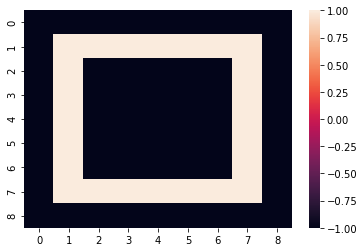

In [4]:
# Setup Bild 1
bild1 = [
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1,  1,  1,  1,  1,  1,  1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1,  1,  1,  1,  1,  1,  1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1]
]

print(np.array(bild1))
_ = heatmap(bild1)

[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]


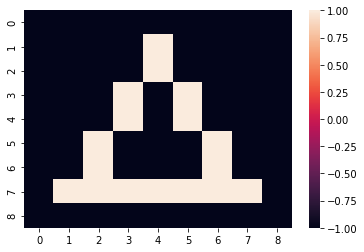

In [5]:
# Setup Bild 2
bild2 = [
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1,  1, -1, -1, -1, -1],
    [-1, -1, -1, -1,  1, -1, -1, -1, -1],
    [-1, -1, -1,  1, -1,  1, -1, -1, -1],
    [-1, -1, -1,  1, -1,  1, -1, -1, -1],
    [-1, -1,  1, -1, -1, -1,  1, -1, -1],
    [-1, -1,  1, -1, -1, -1,  1, -1, -1],
    [-1,  1,  1,  1,  1,  1,  1,  1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1]
]

print(np.array(bild2))
_ = heatmap(bild2)

In [6]:
# Setup kernels

kernel1 = [
    [-1,  1, -1],
    [-1,  1, -1],
    [ 1, -1,  1]
]

kernel2 = [
    [-1, 1, -1],
    [-1, 1, -1],
    [ 1, 1,  1]
]

kernel3 = [
    [1,  1,  1],
    [1, -1, -1],
    [1, -1, -1]
]

kernel4 = [
    [ 1,  1, 1],
    [-1, -1, 1],
    [-1, -1, 1]
]

kernel5 = [
    [1, -1, -1],
    [1, -1, -1],
    [1,  1,  1]
]

kernel6 = [
    [-1, -1, 1],
    [-1, -1, 1],
    [ 1, -1, 1]
]

In [7]:
class Pixel:
    
    def __init__(self, row: int, column: int):
        self.row = row
        self.column = column
        self.__original_column = column
    
    def get_info_from_image(self, img: list):
        return img[self.row][self.column]
    
    def move_to_next_line(self):
        self.row += 1
        self.column = self.__original_column
    
    def __repr__(self):
        return f"({self.row}, {self.column})"

In [8]:
def kernel_iterate(kernel: list, bild: list):
    """kernel und bild sollten eine Liste mit weiteren Listen als Inhalt sein."""
    
    ergebnis = [] # die fertige feature map
    ziel = [] # aktuell betrachterter Ausschnitt
    
    frame = [] # ist die aktuelle Position des Kernels
    for i in range(len(kernel)):
        for j in range(len(kernel[i])):
            frame.append(Pixel(i, j));
    
    # Ausschnitt wird aktualisiert
    for i in range(2, 9, 3):
        ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])

    # durch alle Pixel des Bilds durchiterieren
    for y in range(1, 8):
        for i in range(1, 8):
            zwischenspeicher = []
            
            for k, element in enumerate(kernel):
                for j, zahl in enumerate(ziel[k]):
                    zwischenspeicher.append(element[j] * zahl)
                    
            ergebnis.append(np.average(zwischenspeicher))

            # die Kernelposition um eine Spalte verschieben 
            for pixel in frame:
                pixel.column += 1
            
            # Ende des Bilds erreicht
            if frame[2].column < len(bild[0]):
                ziel = []
                # Ausschnitt neu bestimmen
                for i in range(2, 9, 3):
                    ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])
        
        # Kernelposition um eine Zeile verschieben
        for pixel in frame:
            pixel.move_to_next_line()
        
        # Ende des Bilds erreicht
        if frame[6].row < len(bild):
            ziel = []
            # Ausschnitt neu bestimmen
            for i in range(2, 9, 3):
                ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])
    return ergebnis

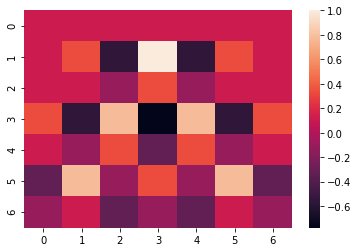

In [9]:
ergebnis = kernel_iterate(kernel1, bild2)

DIMENSIONS = 7

_ = heatmap(prepare_for_heatmap(ergebnis, DIMENSIONS, DIMENSIONS))

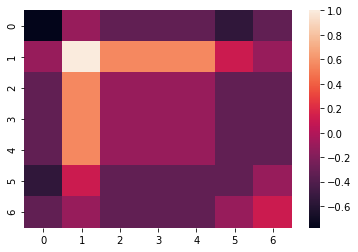

In [10]:
ergebnis = kernel_iterate(kernel3, bild1)

DIMENSIONS = 7

_ = heatmap(prepare_for_heatmap(ergebnis, DIMENSIONS, DIMENSIONS))

In [11]:
def relu(liste: list):
    ergebnis = []
    for zahl in liste:
        if zahl < 0:
            a = 0
        else:
            a = zahl
        ergebnis.append(a)
    return ergebnis

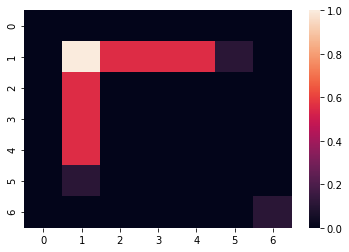

In [12]:
ergebnis = kernel_iterate(kernel3, bild1)
ergebnisRelu = relu(ergebnis)
i = 0
a = 0
b = 7
e1heat = []
while i < 7:
    e1heat.append(ergebnisRelu[a:b])
    a = a + 7
    b = b + 7
    i = i + 1
e1heat
_ = heatmap(e1heat)

In [17]:
def pooling(ergMa: list):
    """Die Ergebnismatrix (ergMa) sollte eine Liste mit weiteren Listen als Inhalt sein."""
    ergebnis = []
    a = 0
    b = 0
    c = 0
    d = 1
    e = 1
    f = 0
    g = 1
    h = 1

    #Pruefen, ob ungerade Anzahl an Zeilen und Spalten
    if (len(ergMa) % 2) > 0:
        ergMa.append([0, 0, 0, 0, 0, 0, 0, 0])
    if (len(ergMa[0])) % 2 > 0:
        for liste in ergMa:
            liste.append(0)
    print(ergMa)
        
        
    i = 1
    j = 1

    while j < 5:
        while i < 5:
            if (a < 7) and (b < 7): 
                ziel = [ergMa[a][b], ergMa[c][d], ergMa[e][f], ergMa[g][h]]
                ergebnis.append(max(ziel))
                #print("ziel: " + str(ziel))
                #print(str(a) + " " + str(b) + " | " + str(c) + " " + str(d))
                #print(str(e) + " " + str(f) + " | " + str(g) + " " + str(h))  
            b += 2
            d += 2
            f += 2
            h += 2
            
            i += 1
        i = 0
        b = 0
        d = 1
        f = 0
        h = 1
        j += 1
        a += 2
        c += 2
        e += 2
        g += 2
            
    return ergebnis
    
    

8
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1.0, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.1111111111111111, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.1111111111111111, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.1111111111111111, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


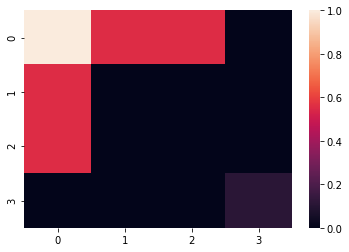

In [18]:
ergMa = pooling(e1heat)

_ = heatmap(prepare_for_heatmap(ergMa, 4, 4))